We're going to be working with `AviationData_cleaned.csv` here. (We started off with `AviationData.csv` and pre-cleaned it, which you can see in `'./notebooks/data_cleaning.ipynb`.)

So we'll start off by loading in pandas, numpy, and matplotlib, and then reading in the DataFrame:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Set the style of the plots to 'fivethirtyeight' -- or something else if you prefer a
# different style.

plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('./data/AviationData_cleaned.csv', encoding='latin-1')
# We'll also read in the US State Codes file to help us with our geographic sorting:
state_codes = pd.read_csv('./data/USState_Codes.csv')

# Take a look at the basic structure of the data:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21065 entries, 0 to 21064
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.ID                21065 non-null  object 
 1   Investigation.Type      21065 non-null  object 
 2   Accident.Number         21065 non-null  object 
 3   Event.Date              21065 non-null  object 
 4   Year                    21065 non-null  int64  
 5   Location                21065 non-null  object 
 6   State.Code              21065 non-null  object 
 7   State.Name              21065 non-null  object 
 8   Region                  21065 non-null  object 
 9   Latitude                17904 non-null  object 
 10  Longitude               17897 non-null  object 
 11  Airport.Code            14795 non-null  object 
 12  Airport.Name            15202 non-null  object 
 13  Injury.Severity         20991 non-null  object 
 14  Num.Fatalities          21065 non-null

c:\Users\nateh\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (20,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Purpose of Flight

The first way we'll slice up our data is using the `Purpose.Binned` category, since we (1) want to figure out if there are safer and less safe purposes to which planes are used and then (2) if there are certain types of airplane that are safer for that specific type of activity. 

In [4]:
df['Purpose.Binned'].value_counts(normalize=True)

personal              0.655693
instructional         0.153730
aerial application    0.051042
business              0.048072
unknown               0.027685
positioning           0.016913
private transport     0.014346
recreational          0.009665
aerial observation    0.007702
flight test           0.005738
public - govt         0.005084
air show              0.002416
public transport      0.001913
Name: Purpose.Binned, dtype: float64

c:\Users\nateh\anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


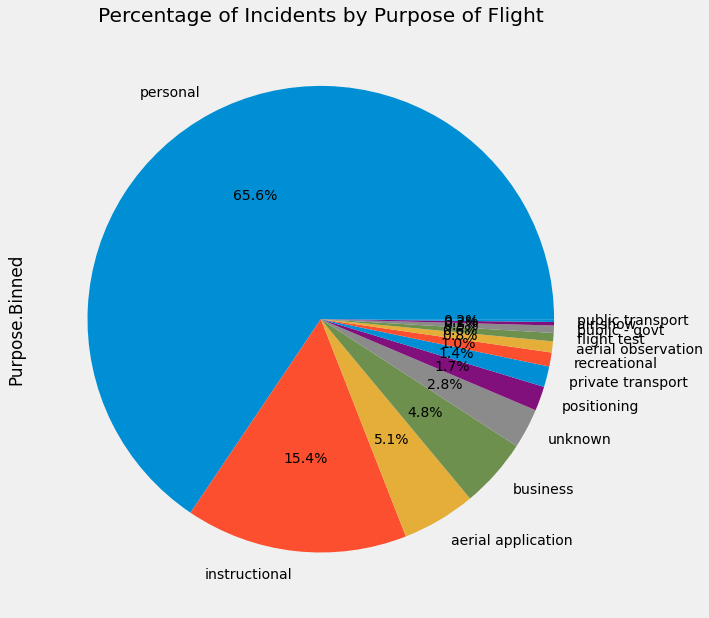

In [12]:
df['Purpose.Binned'].value_counts(normalize=True).plot(
    kind='pie', 
    figsize=(10, 10),
    title = 'Percentage of Incidents by Purpose of Flight',
    autopct='%1.1f%%'
);

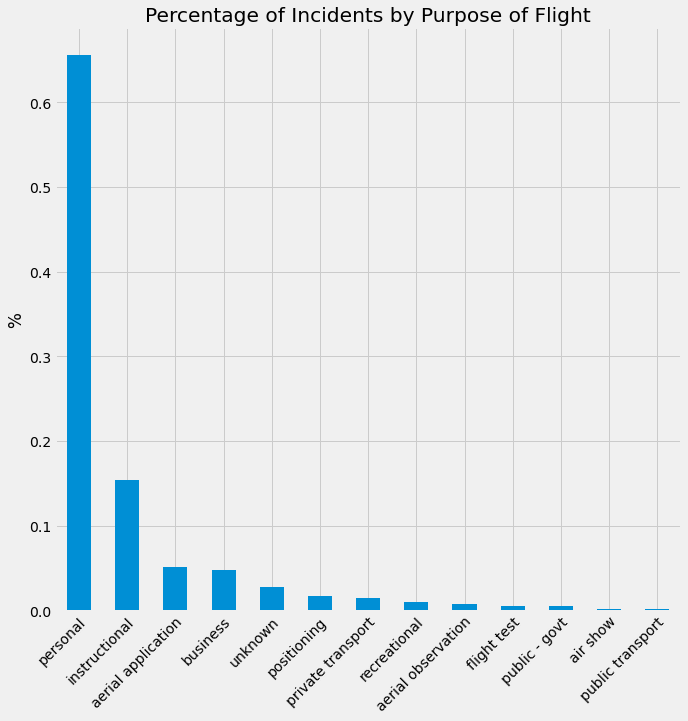

In [30]:
# Since no one likes pie charts, we can also take a look at this data as a barchart:
ax = df['Purpose.Binned'].value_counts(normalize=True).plot(kind='bar', figsize=(10, 10))
plt.title('Percentage of Incidents by Purpose of Flight')
plt.ylabel('%')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor');

What can we see in the above graphs? Most importantly, the vast majority of incident reports stem from "personal" flights. Unfortunately, we don't have the total number of flights -- i.e., including those for which no incident was reported -- so we will need to explore other ways of judging the safety of the different purposes above.

### Personal Injury & Purpose of Flight

The first way we'll try to judge the safety of these different purposes of flight is using the number of people injured in a given incident. These data are found in `Total.Fatal.Injuries`, `Total.Serious.Injuries`, and `Total.Minor.Injuries`. We'll also initially include `Total.Uninjured` to see if that might be a helpful metric.

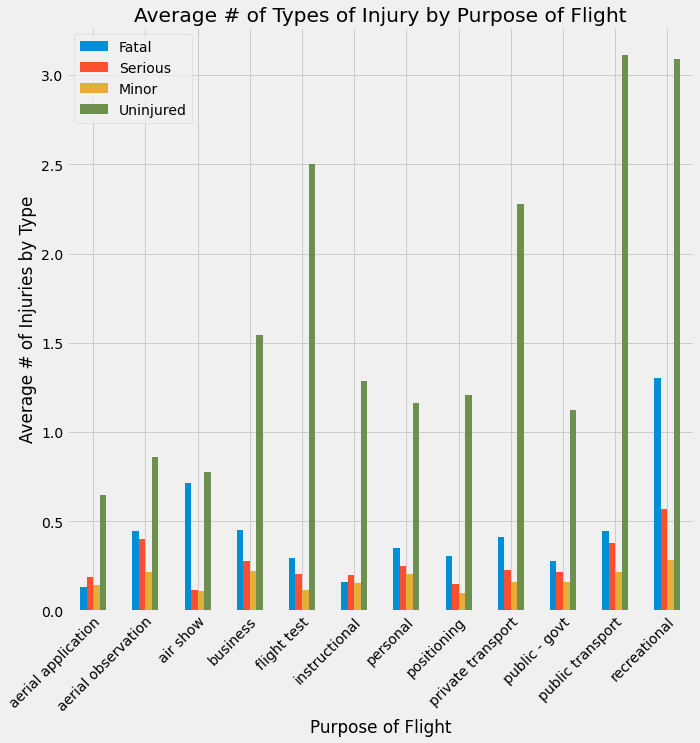

In [41]:
# Start by creating a new dataframe that includes the columns we want to look at, grouped by the purpose of flight:
injury_df = df.groupby('Purpose.Binned').mean().filter(['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured'])

#Dropping unknown from the 'purpose_binned' column of injury_df
ax = injury_df.drop('unknown').plot(kind='bar', figsize=(10, 10))
plt.title('Average # of Types of Injury by Purpose of Flight')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel('Purpose of Flight')
plt.ylabel('Average # of Injuries by Type')
ax.legend(['Fatal', 'Serious', 'Minor', 'Uninjured']);

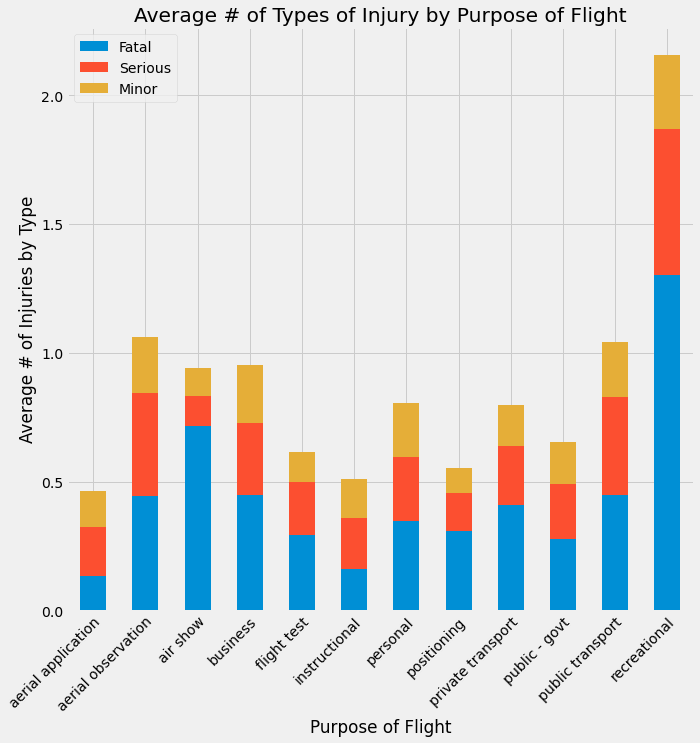

In [28]:
# It turns out we probably didn't want to include the uninjured count, so we'll
# redo the chart without that column. We'll also use a stacked bar chart, so we can 
# more easily compare the total number of injuries by purpose of flight:

# Repeating the above chart, but without the non-injuries.
injury_df = df.groupby('Purpose.Binned').mean().filter(['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries'])

#Dropping unknown from the 'purpose_binned' column of injury_df
ax = injury_df.drop('unknown').plot(kind='bar', stacked=True, figsize=(10, 10))
plt.title('Average # of Types of Injury by Purpose of Flight')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel('Purpose of Flight')
plt.ylabel('Average # of Injuries by Type')
ax.legend(['Fatal', 'Serious', 'Minor']);

We can now see that **aerial application** (which corresponds to, and which we will usually refer to as **agriculture**) and **flight test** are the purposes which produce the fewest average injuries per incident. On the flip side, entries for **recreational** flights typically report many more injuries than *any* of the other categories (and especially agriculture and instruction).

## Damage to Plane & Purpose of Flight

We also want to take a look at the extent of damage that is typically reported in incidents, grouped again by the different purposes. (Again, it's worth emphasizing that this doesn't tell us *which planes are more likely to sustain certain damage*, but rather *given that there is an incident report for a certain type of flight, what type of damage we will typically expect.*)

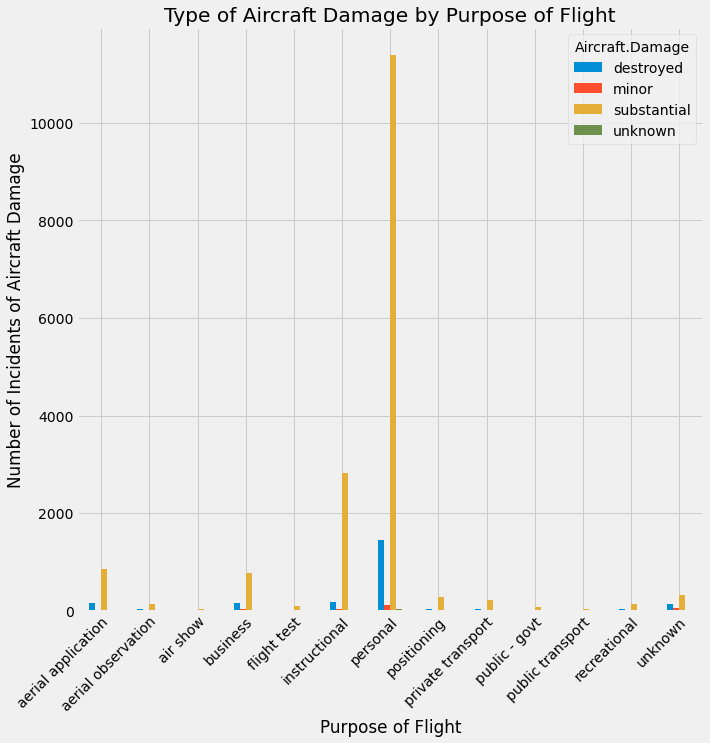

In [27]:
# Create a plot that shows the frequency of the different types of results 
# in Aircraft.Damage, again grouped according to Purpose.Binned.

df.groupby(['Purpose.Binned', 'Aircraft.Damage']).size().unstack().plot(kind='bar', figsize=(10, 10))
plt.title('Type of Aircraft Damage by Purpose of Flight')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel('Purpose of Flight')
plt.ylabel('Number of Incidents of Aircraft Damage');



There are so many more incidents of damage reported for personal flights that it makes it difficult to understand the rest of the graph. (Again, we can't draw huge conclusions from this, since there may be many more total personal flights than other types of flights.)

We might get slightly more useful information if we look at the percentages of the different types of damage reported:

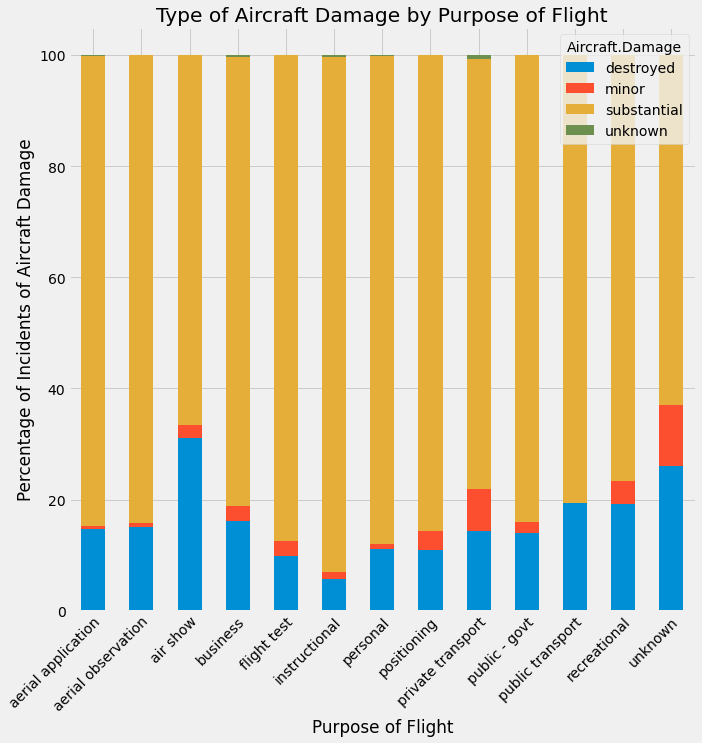

In [26]:
df.groupby(['Purpose.Binned', 'Aircraft.Damage']).size().unstack().apply(lambda x: x/x.sum() * 100, axis=1).plot(kind='bar', stacked=True, figsize=(10, 10))
plt.title('Type of Aircraft Damage by Purpose of Flight')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel('Purpose of Flight')
plt.ylabel('Percentage of Incidents of Aircraft Damage');

What do we learn here? First, air shows incidents (unsurpisingly) tend to result in destruction of the airplane more often than incidents for other flight purposes. Additionally, we can see that instructional flights will involve a destroyed plane less often. Again, that makes sense since you have a very competent pilot overseeing the operations of the plane.

# Makes of Planes

We now want to check out whether certain makes of planes are safer than others. We also want to see if certain makes of planes are safer for certain uses -- in our case, given that we are emphasizing safety, for the purposes of agriculture (aerial application) and instruction.

We already did a significant amount of cleaning of the `Make` column in our `data_cleaning.ipynb`, so let's check it out: 

In [34]:
df['Make'].value_counts()

cessna                            7712
piper                             4357
beech                             1520
boeing                             446
mooney                             437
                                  ... 
mccleery                             1
europro cz                           1
cobalt aircraft industries inc       1
british aircraft corp.               1
vought                               1
Name: Make, Length: 968, dtype: int64

We still have 968 different types of plane listed. We also have a large number of planes that only have one or two entries total (you can run a `df['Make'].value_counts().tail(25)` to take a look.) Since we're looking at getting into the aviation business, we'll want to direct our attention to the more common makes, since (1) people will be more familiar with those makes, (2) they'll be more ubiquitous and therefore more likely to be easily serviced and maintaned, and (3) they'll have a longer safety track record. 

We'll start off by making `top_25_df`, which only contains entries that include one of the 25 most common makes. We'll also then make a `top_10_df`, which will turn out to be more helpful in visualizing the data relevant for our purposes.

In [35]:
# Making a new df that only accepts the top 25 makes:
top_25 = df['Make'].value_counts().head(25).index.tolist()
top_25_df = df[df['Make'].isin(top_25)].copy()
top_25_df['Make'].value_counts()

cessna                       7712
piper                        4357
beech                        1520
boeing                        446
mooney                        437
airtractor                    414
grumman                       409
cirrus                        328
bellanca                      279
aeronca                       226
maule                         225
dehavilland                   164
champion                      164
luscombe                      162
stinson                       145
north american                113
taylorcraft                   109
aero commander                 94
embraer                        85
airbus                         79
aviat aircraft inc             76
diamond aircraft ind inc       73
aviat                          68
ercoupe                        66
raytheon aircraft company      61
Name: Make, dtype: int64

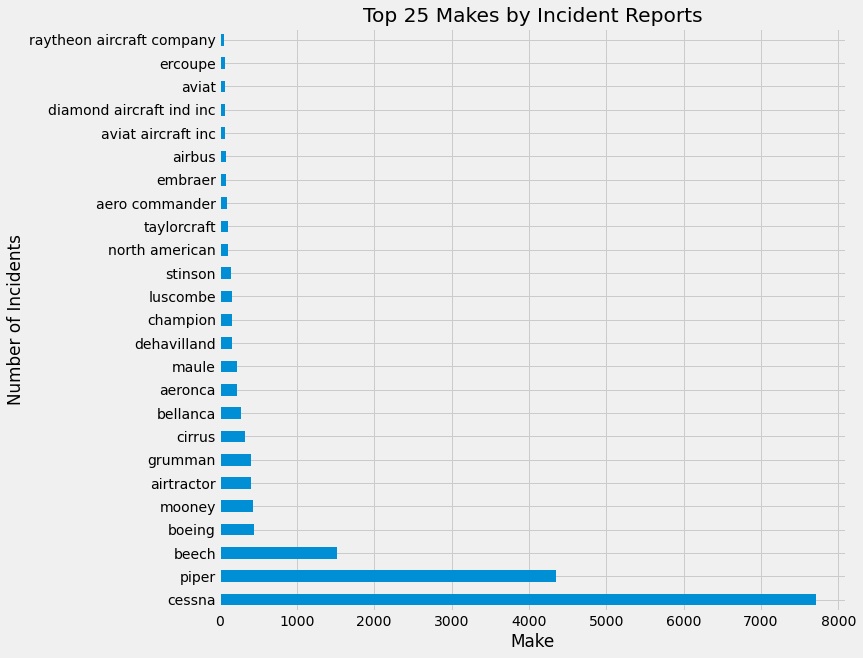

In [36]:
# And we can display the information visually:
top_25_df['Make'].value_counts().plot(kind='barh', figsize=(10, 10))
plt.title('Top 25 Makes by Incident Reports')

plt.xlabel('Make')
plt.ylabel('Number of Incidents');

In [37]:
# We'll repeat the same process to make our top_ten_df:
top_10 = df['Make'].value_counts().head(10).index.tolist()
top_10_df = df[df['Make'].isin(top_10)].copy()
top_10_df['Make'].value_counts()

cessna        7712
piper         4357
beech         1520
boeing         446
mooney         437
airtractor     414
grumman        409
cirrus         328
bellanca       279
aeronca        226
Name: Make, dtype: int64

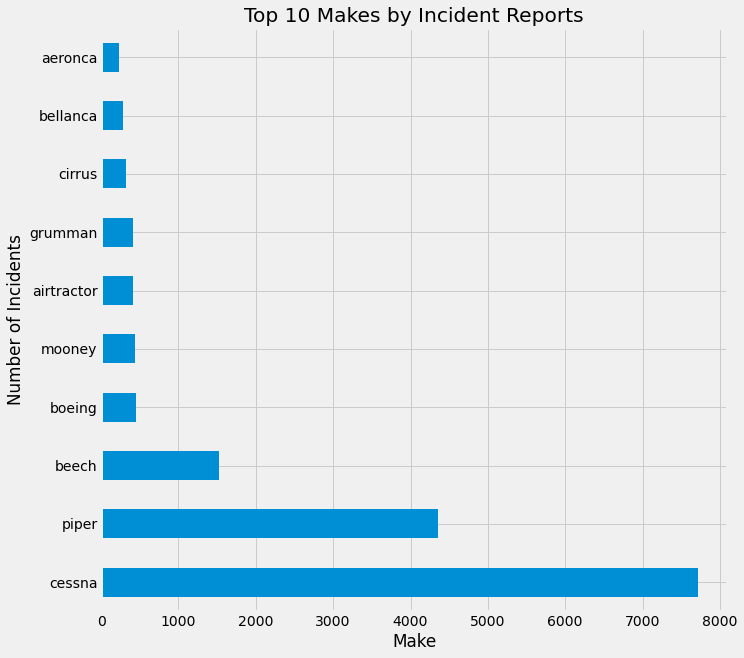

In [39]:
# and chart  the frequencies of the top 10

top_10_df['Make'].value_counts().plot(kind='barh', figsize=(10, 10))
plt.title('Top 10 Makes by Incident Reports')
plt.xlabel('Make')
plt.ylabel('Number of Incidents');

# Personal Injury & Airplane Make

Now that we have these two DataFrames to work with, we can try to judge the relative safety of the different makes of plane. We'll start off again by looking at the average number of injuries for each incident, once again broken down into fatal, serious, and minor. (In this case, we are preemptively excluding the non-injury category.) 

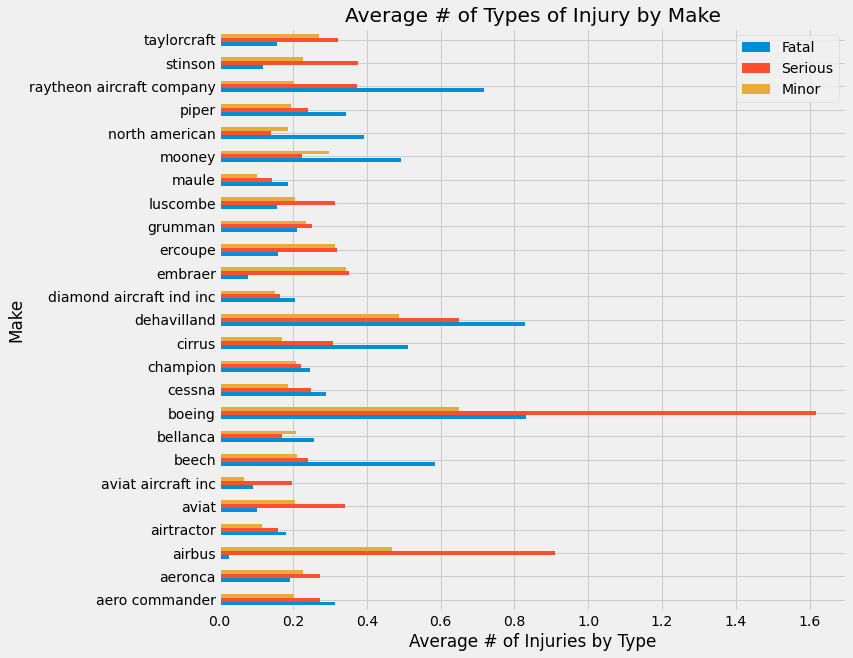

In [43]:
ax = top_25_df.groupby('Make').mean().filter(['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries']).plot(kind='barh', figsize=(10, 10))
plt.title('Average # of Types of Injury by Make')
plt.xlabel('Average # of Injuries by Type')
plt.ylabel('Make')
ax.legend(['Fatal', 'Serious', 'Minor']);

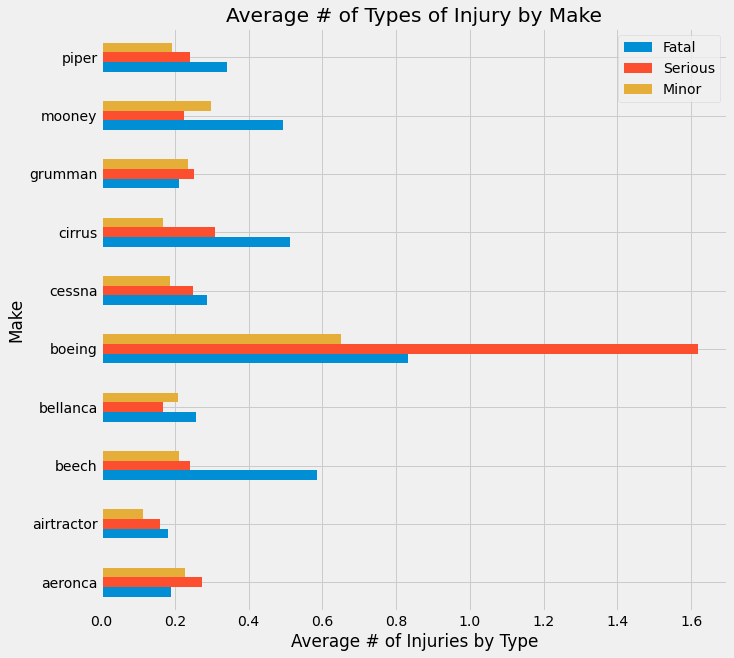

In [45]:
ax = top_10_df.groupby('Make').mean().filter(['Injury.Severity', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries']).plot(kind='barh', figsize=(10, 10))
plt.title('Average # of Types of Injury by Make')
plt.xlabel('Average # of Injuries by Type')
plt.ylabel('Make')
ax.legend(['Fatal', 'Serious', 'Minor']);